# Check local solution

In this notebook, we want to verify the `LeafNode` object is computing an acceptable solution to the inhomogeneous Helmholtz equation. 

In [11]:
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
# I have to do this because I'm running the notebook in the checks/ directory
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:

from src.interior_solution import LeafNode
from src.utils import differentiation_matrix_1d, chebyshev_points, points_to_2d_lst_of_points

### Set up geometric information about the local grid, as well as a simple scattering object

In [4]:
DOMAIN_MAX = 0.5
N_CHEB_PTS = 50
N_GAUSS_PTS = 50
UPPER_LEFT_X = -0.5
UPPER_LEFT_Y = 0.5


In [16]:
x = torch.linspace(-DOMAIN_MAX, DOMAIN_MAX, N_CHEB_PTS)
pts_lst = points_to_2d_lst_of_points(x)
radii = torch.linalg.norm(pts_lst, axis=1)

scattering_obj = 1e-04 * (torch.exp(-1 * radii))
obj_for_plt = scattering_obj.numpy().reshape(N_CHEB_PTS, N_CHEB_PTS)

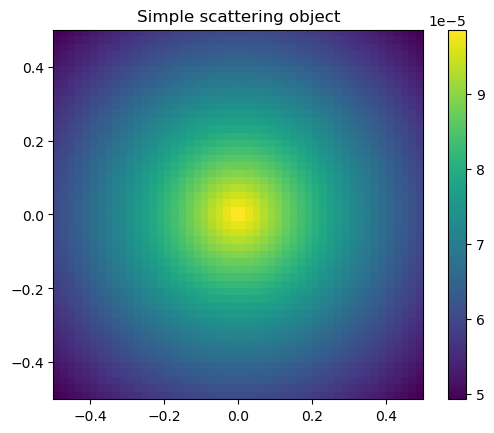

In [17]:
plt.imshow(obj_for_plt, extent=np.array([-DOMAIN_MAX, DOMAIN_MAX, -DOMAIN_MAX, DOMAIN_MAX]))
plt.colorbar()
plt.title('Simple scattering object')
plt.show()